In [1]:
#%%
"""
Created on Thu Dec 12 2018
Hedging with the Black Scholes model
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum
from mpl_toolkits import mplot3d
from scipy.interpolate import RegularGridInterpolator

In [2]:
# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

def GeneratePathsGBM(NoOfPaths,NoOfSteps,T,r,sigma,S_0):
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    time = np.zeros([NoOfSteps+1])

    X[:,0] = np.log(S_0)

    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        X[:,i+1] = X[:,i] + (r - 0.5 * sigma * sigma) * dt + sigma * (W[:,i+1]-W[:,i])
        time[i+1] = time[i] +dt

    #Compute exponent of ABM
    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

# Black-Scholes Call option price
def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))
    * (T-t)) / (sigma * np.sqrt(T-t))
    d2    = d1 - sigma * np.sqrt(T-t)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * (T-t))
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * (T-t)) - st.norm.cdf(-d1)*S_0
    return value

def BS_Delta(CP,S_0,K,sigma,t,T,r):
    # when defining a time-grid it may happen that the last grid point
    # is slightly after the maturity
    if t-T>10e-20 and T-t<10e-7:
        t=T
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * \
             (T-t)) / (sigma * np.sqrt(T-t))
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1)
    elif CP == OptionType.PUT:
       value = st.norm.cdf(d1)-1.0
    return value


def mainCalculation():
    NoOfPaths = 5000
    NoOfSteps = 1000    ### Hedging Frequency - change this to 10, 25, 100 to see the effect

    T         = 1.0
    r         = 0.1
    sigma     = 0.2
    s0        = 1.0
    K         = [0.95]
    CP        = OptionType.CALL

    np.random.seed(1)
    Paths = GeneratePathsGBM(NoOfPaths,NoOfSteps,T,r,sigma,s0)
    time  = Paths["time"]
    S     = Paths["S"]

    # Setting up some handy lambdas
    C = lambda t,K,S0: BS_Call_Put_Option_Price(CP,S0,K,sigma,t,T,r)
    Delta = lambda t,K,S0: BS_Delta(CP,S0,K,sigma,t,T,r)

    # Setting up initial portfolio
    PnL = np.zeros([NoOfPaths,NoOfSteps+1])
    delta_init= Delta(0.0,K,s0)
    PnL[:,0] = C(0.0,K,s0) - delta_init * s0

    CallM      = np.zeros([NoOfPaths,NoOfSteps+1])
    CallM[:,0] = C(0.0,K,s0)
    DeltaM     = np.zeros([NoOfPaths,NoOfSteps+1])
    DeltaM[:,0] = Delta(0,K,s0)

    for i in range(1,NoOfSteps+1):
        dt = time[i] - time[i-1]
        delta_old  = Delta(time[i-1],K,S[:,i-1])
        delta_curr = Delta(time[i],K,S[:,i])

        PnL[:,i]    =  PnL[:,i-1]*np.exp(r*dt) - (delta_curr-delta_old)*S[:,i] # PnL
        CallM[:,i]  = C(time[i],K,S[:,i])
        DeltaM[:,i] = delta_curr

    # Final transaction, payment of the option (if in the money) and selling the hedge
    PnL[:,-1] = PnL[:,-1] -np.maximum(S[:,-1]-K,0) +  DeltaM[:,-1]*S[:,-1]

    # We plot only one path at the time
    path_id = 13
    plt.figure(1)
    plt.plot(time,S[path_id,:])
    plt.plot(time,CallM[path_id,:])
    plt.plot(time,DeltaM[path_id,:])
    plt.plot(time,PnL[path_id,:])
    plt.legend(['Stock','CallPrice','Delta','PnL'])
    plt.grid()

    # Plot the histogram of PnL
    plt.figure(2)
    plt.hist(PnL[:,-1],50)
    plt.grid()
    plt.xlim([-0.1,0.1])
    plt.title('histogram of P&L')

    # Analysis for each path
    #for i in range(0,NoOfPaths):
    #    print('path_id = {0:2d}, PnL(t_0)={1:0.4f}, PnL(Tm-1) ={2:0.4f},S(t_m) = {3:0.4f}, max(S(tm)-K,0)= {4:0.4f}, PnL(t_m) = {5:0.4f}'.format(i,PnL[0,0],
    #          PnL[i,-2],S[i,-1],np.max(S[i,-1]-K,0),PnL[i,-1]))

/var/folders/n8/19ypk1rs6tdbh7vcb43bfl0c0000gn/T/ipykernel_1152/3572029748.py:46: RuntimeWarning: divide by zero encountered in divide
  d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * \
/var/folders/n8/19ypk1rs6tdbh7vcb43bfl0c0000gn/T/ipykernel_1152/3572029748.py:32: RuntimeWarning: invalid value encountered in sqrt
  * (T-t)) / (sigma * np.sqrt(T-t))
/var/folders/n8/19ypk1rs6tdbh7vcb43bfl0c0000gn/T/ipykernel_1152/3572029748.py:33: RuntimeWarning: invalid value encountered in sqrt
  d2    = d1 - sigma * np.sqrt(T-t)


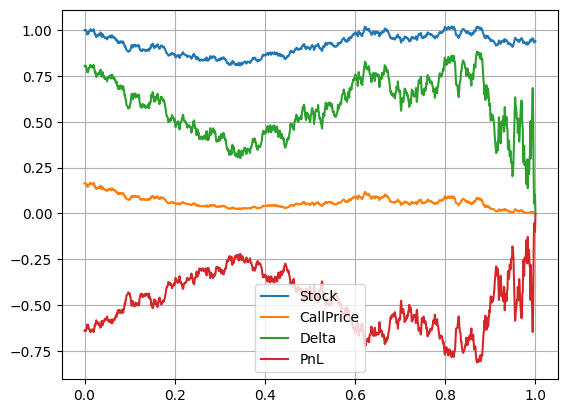

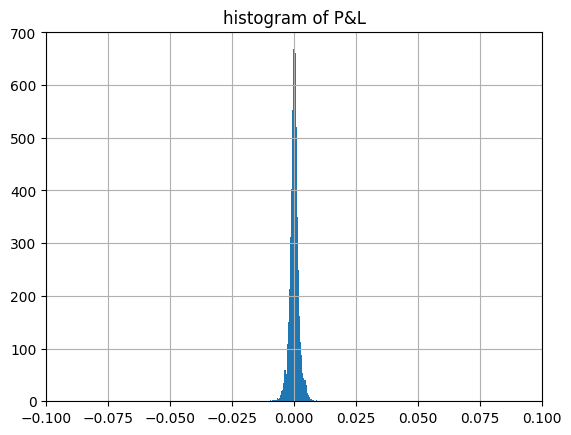

In [3]:
mainCalculation()